In [0]:
#@title Download dataset

from google.colab import files
files.upload()

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [0]:
train_df = pd.read_csv("training.csv")
test_df = pd.read_csv("predict.csv")

In [121]:
train_df.shape

(9418, 72)

In [122]:
train_df.head()

,id,posted_time,updated_time,age,updated_age,app_type,owner_id,owner_type,owner_influence,number_of_likes,number_of_comments,reactivity,is_mentions_me,is_mentions_connections,is_commented_by_me,is_commented_by_connections,is_liked_by_me,is_liked_by_connections,poster_id,poster_gender,poster_is_employee,poster_is_lead,poster_is_in_connections,poster_focus,poster_order,poster_influence,participant1_id,participant1_action,participant1_gender,participant1_is_employee,participant1_is_lead,participant1_is_in_connections,participant1_focus,participant1_order,participant1_influence,participant2_id,participant2_action,participant2_gender,participant2_is_employee,participant2_is_lead,participant2_is_in_connections,participant2_focus,participant2_order,participant2_influence,participant3_id,participant3_action,participant3_gender,participant3_is_employee,participant3_is_lead,participant3_is_in_connections,participant3_focus,participant3_order,participant3_influence,participant4_id,participant4_action,participant4_gender,participant4_is_employee,participant4_is_lead,participant4_is_in_connections,participant4_focus,participant4_order,participant4_influence,participant5_id,participant5_action,participant5_gender,participant5_is_employee,participant5_is_lead,participant5_is_in_connections,participant5_focus,participant5_order,participant5_influence,rank
0,175339,1.514050e+12,1.514050e+12,6.315242e+10,6.315242e+10,other,57727,space,0.99973,1,0,1.00000,0,0,0,0,0,1,5,male,1,0,1,marketing,6,0.99962,146,liked,male,1,0,1,marketing,5,0.99899,22636,viewed,male,0,0,1,other,4,0.23077,3080,viewed,male,0,0,1,marketing,3,0.23077,44661,viewed,male,0,0,1,other,2,0.23077,3089,viewed,male,0,0,1,other,1,0.23077,0.73677
1,175348,1.514110e+12,1.515160e+12,6.309278e+10,6.204696e+10,forum,111913,space,0.99977,0,2,0.12336,0,0,0,1,0,0,146,male,1,0,1,marketing,6,0.99899,13659,commented,male,0,0,0,other,5,0.99756,146,commented,male,1,0,1,marketing,4,0.99899,22636,viewed,male,0,0,1,other,3,0.23077,3080,viewed,male,0,0,1,marketing,2,0.23077,44661,viewed,male,0,0,1,other,1,0.23077,0.78240
2,175353,1.514120e+12,1.515160e+12,6.309049e+10,6.204716e+10,forum,111913,space,0.99977,0,3,0.12336,0,0,0,1,0,0,146,male,1,0,1,marketing,6,0.99899,13659,commented,male,0,0,0,other,5,0.99756,13,commented,male,1,0,1,marketing,4,0.99895,146,commented,male,1,0,1,marketing,3,0.99899,22636,viewed,male,0,0,1,other,2,0.23077,3080,viewed,male,0,0,1,marketing,1,0.23077,0.82125
3,175371,1.514190e+12,1.514190e+12,6.301324e+10,6.301324e+10,other,9037,space,0.99949,0,0,0.00000,0,0,0,0,0,0,7,male,1,0,1,marketing,6,0.99886,22636,viewed,male,0,0,1,other,5,0.23077,3080,viewed,male,0,0,1,marketing,4,0.23077,44661,viewed,male,0,0,1,other,3,0.23077,3089,viewed,male,0,0,1,other,2,0.23077,3084,viewed,male,0,0,1,marketing,1,0.23077,0.61522
4,175372,1.514190e+12,1.514190e+12,6.301323e+10,6.301323e+10,other,9037,space,0.99949,0,0,0.00000,0,0,0,0,0,0,7,male,1,0,1,marketing,6,0.99886,22636,viewed,male,0,0,1,other,5,0.23077,3080,viewed,male,0,0,1,marketing,4,0.23077,44661,viewed,male,0,0,1,other,3,0.23077,3089,viewed,male,0,0,1,other,2,0.23077,3084,viewed,male,0,0,1,marketing,1,0.23077,0.61522


# **Age column investigation**
Here I'll research and investigate how do we can proceed with 'age' column

In [0]:
import datetime
import time

# date of dataset creation
DATE = '4/02/2020'

current_date = datetime.datetime.strptime(DATE, "%d/%m/%Y")
current_secs = time.mktime(current_date.timetuple())

In [0]:
def get_date(secs):
  return datetime.datetime.fromtimestamp(current_secs - secs).strftime("%A, %B %d, %Y %I:%M:%S")

In [0]:
# convert time from miliseconds to seconds
train_df.age /= 1000

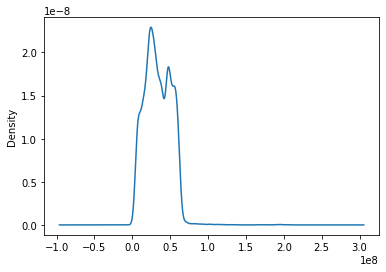

In [0]:
train_df.age.plot.kde()

In [0]:
train_df.age.describe()

count    9.418000e+03
mean     3.393422e+07
std      1.738314e+07
min      4.147070e+06
25%      2.108517e+07
50%      3.214917e+07
75%      4.719412e+07
max      2.050660e+08
Name: age, dtype: float64

In [0]:
# first day of the 2018 year, all previous dates will be removed from the dataset
get_date(6.6 * 1e+07)

'Monday, January 01, 2018 02:40:00'

In [0]:
filtered_data = [e for e in  filter(lambda x : x < 6.6 * 1e+07, sorted(train_df.age))]
len(filtered_data)

9339

In [0]:
# remove all dates before 2018 year
train_df = train_df[train_df.age.isin(filtered_data)]

In [0]:
train_df.age.describe()

count    9.339000e+03
mean     3.339512e+07
std      1.605928e+07
min      4.147070e+06
25%      2.100618e+07
50%      3.193247e+07
75%      4.697468e+07
max      6.472692e+07
Name: age, dtype: float64

In [0]:
# first and  last days of new data
get_date(4.147070e+06), get_date(6.472692e+07)

('Wednesday, December 18, 2019 12:02:10', 'Monday, January 15, 2018 08:18:00')

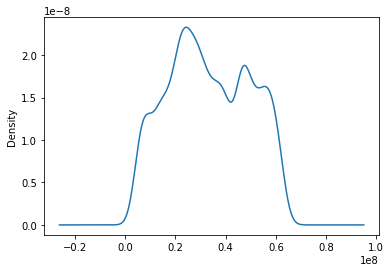

In [0]:
train_df.age.plot.kde()

In [0]:
# function to count number of post in each month for 2018 and 2019 years
def count_posts_per_month(ages):
  dates = [get_date(a) for a in ages]

  months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
  
  count_2018 = {m : 0 for m in months}
  count_2019 = {m : 0 for m in months}


  for date in dates:
    date_splitted = date.split(" ")
    month = date_splitted[1]
    year = date_splitted[3]

    if year == "2018":
      count_2018[month] += 1
    elif year == "2019":
      count_2019[month] += 1
    else:
      print(date)
  
  return count_2018, count_2019


In [0]:
def plot_posts_by_month(counts):
  plt.bar(range(len(counts)), list(counts.values()), align='center')
  plt.xticks(range(len(counts)), list(counts.keys()))
  plt.show()


In [0]:
counts = count_posts_per_month(filtered_data)

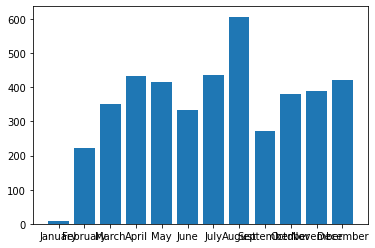

In [0]:
# 2018 year
plot_posts_by_month(counts[0])

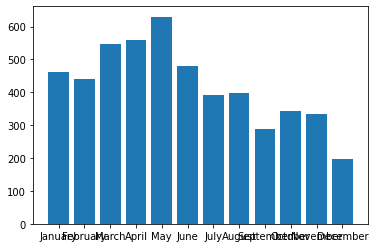

In [0]:
# 2019 year
plot_posts_by_month(counts[1])

# **Prediction data analysis**

In [123]:
test_df.head()

,id,posted_time,updated_time,age,updated_age,app_type,owner_id,owner_type,owner_influence,number_of_likes,number_of_comments,reactivity,is_mentions_me,is_mentions_connections,is_commented_by_me,is_commented_by_connections,is_liked_by_me,is_liked_by_connections,poster_id,poster_gender,poster_is_employee,poster_is_lead,poster_is_in_connections,poster_focus,poster_order,poster_influence,participant1_id,participant1_action,participant1_gender,participant1_is_employee,participant1_is_lead,participant1_is_in_connections,participant1_focus,participant1_order,participant1_influence,participant2_id,participant2_action,participant2_gender,participant2_is_employee,participant2_is_lead,participant2_is_in_connections,participant2_focus,participant2_order,participant2_influence,participant3_id,participant3_action,participant3_gender,participant3_is_employee,participant3_is_lead,participant3_is_in_connections,participant3_focus,participant3_order,participant3_influence,participant4_id,participant4_action,participant4_gender,participant4_is_employee,participant4_is_lead,participant4_is_in_connections,participant4_focus,participant4_order,participant4_influence,participant5_id,participant5_action,participant5_gender,participant5_is_employee,participant5_is_lead,participant5_is_in_connections,participant5_focus,participant5_order,participant5_influence
0,273721,1.575530e+12,1.575530e+12,1.686167e+09,1.686167e+09,other,57727,space,0.99973,13,7,0,0,1,0,1,0,1,119825,female,1,0,0,other,6,0.99754,5,commented,male,1,0,1,marketing,5,0.99962,129104,commented,female,1,0,0,marketing,4,0.99500,4,commented,male,1,0,1,marketing,3,0.99867,41,commented,male,1,0,1,sales,2,0.99828,7,commented,male,1,0,1,marketing,1,0.99886
1,273985,1.575580e+12,1.575580e+12,1.634145e+09,1.634145e+09,other,3201,space,0.99992,4,0,0,0,0,0,0,0,1,119825,female,1,0,0,other,6,0.99754,122534,liked,male,1,0,1,marketing,5,0.99678,10,liked,male,1,0,1,marketing,4,0.99902,7,liked,male,1,0,1,marketing,3,0.99886,5,liked,male,1,0,1,marketing,2,0.99962,22636,viewed,male,0,0,1,other,1,0.23077
2,273750,1.575540e+12,1.575540e+12,1.681664e+09,1.681664e+09,other,57727,space,0.99973,2,5,0,0,1,0,1,0,1,129104,female,1,0,0,marketing,6,0.99500,109375,commented,male,1,0,1,marketing,5,0.99715,129104,commented,female,1,0,0,marketing,4,0.99500,4,commented,male,1,0,1,marketing,3,0.99867,108025,commented,male,1,0,0,marketing,2,0.99891,7,commented,male,1,0,1,marketing,1,0.99886
3,273302,1.575370e+12,1.575370e+12,1.852591e+09,1.852591e+09,other,126877,space,0.50000,0,2,0,0,0,0,1,0,0,7,male,1,0,1,marketing,6,0.99886,108025,commented,male,1,0,0,marketing,5,0.99891,7,commented,male,1,0,1,marketing,4,0.99886,22636,viewed,male,0,0,1,other,3,0.23077,3080,viewed,male,0,0,1,marketing,2,0.23077,44661,viewed,male,0,0,1,other,1,0.23077
4,273897,1.575560e+12,1.575560e+12,1.661083e+09,1.661083e+09,other,57727,space,0.99973,4,5,0,0,0,0,1,0,1,109375,male,1,0,1,marketing,6,0.99715,108025,commented,male,1,0,0,marketing,5,0.99891,5,commented,male,1,0,1,marketing,4,0.99962,129104,commented,female,1,0,0,marketing,3,0.99500,146,commented,male,1,0,1,marketing,2,0.99899,4,commented,male,1,0,1,marketing,1,0.99867


In [124]:
test_df.shape

(100, 71)

In [0]:
# conver to seconds
test_df.posted_time /= 1000

In [0]:
def get_date(secs):
  return datetime.datetime.fromtimestamp(secs).strftime("%A, %d/%m/%Y %I:%M:%S")

def get_date_separated(secs):
  date = datetime.datetime.fromtimestamp(secs)
  # return year, month, weekday, hour
  return int(date.strftime("%Y")), int(date.strftime("%m")), date.strftime("%A"), int(date.strftime("%H")), int(date.strftime("%d"))

In [127]:
get_date(test_df.posted_time[0])

'Thursday, 05/12/2019 07:13:20'

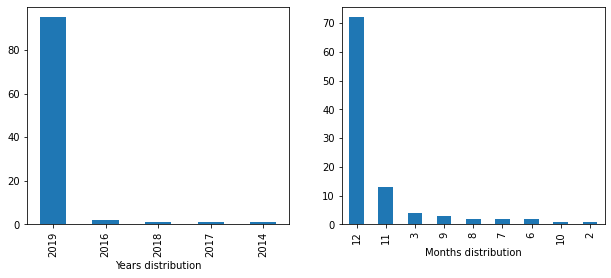

In [128]:
plt.figure(figsize=(16, 4))

plt.subplot(131)
pd.Series([get_date_separated(i)[0] for i in test_df.posted_time]).value_counts().plot(kind="bar")
plt.xlabel('Years distribution')

plt.subplot(132)
pd.Series([get_date_separated(i)[1] for i in test_df.posted_time]).value_counts().plot(kind="bar")
plt.xlabel('Months distribution')

plt.show()

Text(0.5, 0, 'Hours distribution')

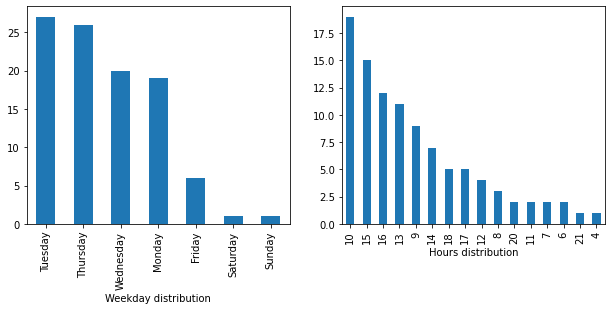

In [129]:
plt.figure(figsize=(16, 4))


plt.subplot(131)
pd.Series([get_date_separated(i)[2] for i in test_df.posted_time]).value_counts().plot(kind="bar")
plt.xlabel('Weekday distribution')


plt.subplot(132)
pd.Series([get_date_separated(i)[3] for i in test_df.posted_time]).value_counts().plot(kind="bar")
plt.xlabel('Hours distribution')


In [130]:
filtered_data = [e for e in  filter(lambda x : get_date_separated(x)[0] == 2019, test_df.posted_time)]
len(filtered_data)

95

In [0]:
# remove all dates before 2019 year
new_test_df = test_df[test_df.posted_time.isin(filtered_data)]

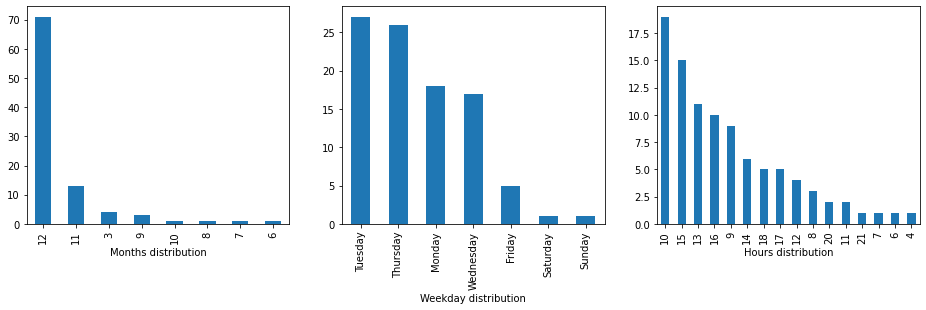

In [132]:
# plot prediction data only for 2019 year 
plt.figure(figsize=(16, 4))

plt.subplot(131)
pd.Series([get_date_separated(i)[1] for i in new_test_df.posted_time]).value_counts().plot(kind="bar")
plt.xlabel('Months distribution')

plt.subplot(132)
pd.Series([get_date_separated(i)[2] for i in new_test_df.posted_time]).value_counts().plot(kind="bar")
plt.xlabel('Weekday distribution')


plt.subplot(133)
pd.Series([get_date_separated(i)[3] for i in new_test_df.posted_time]).value_counts().plot(kind="bar")
plt.xlabel('Hours distribution')

plt.show()

In [0]:
# filter posted_time for December 2019, month with majority of the posts
filtered_by_month = [get_date_separated(e)[4] for e in  filter(lambda x : get_date_separated(x)[1] == 12, new_test_df.posted_time)]
december = pd.Series(sorted(filtered_by_month))

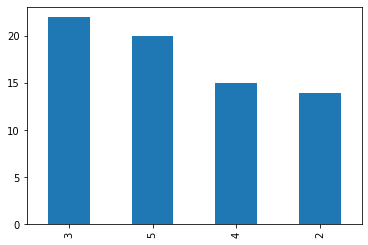

In [134]:
december.value_counts().plot(kind="bar")